In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline,  GenerationConfig
from accelerate import Accelerator

/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-11-19 07:04:51,987] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
import numpy as np
import os
import sys
import os
from tqdm import tqdm
import numpy as np
import torch
sys.path.append(".")
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
from datasets import load_dataset
from accelerate import Accelerator
from torch.utils.data import DataLoader
from utils.template import TEMPLATE_DICT
import seaborn as sns
from matplotlib import pyplot as plt

#configs
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
template = TEMPLATE_DICT['alpaca'][0]
MODEL_NAME = 'TinyLlama/TinyLlama_v1.1'
DATASET_NAME = 'dominguesm/alpaca-data-pt-br'
DEVICE = 'cuda'
NUM_CHECKPOINTS = 20
EVALSET_LEN = 50

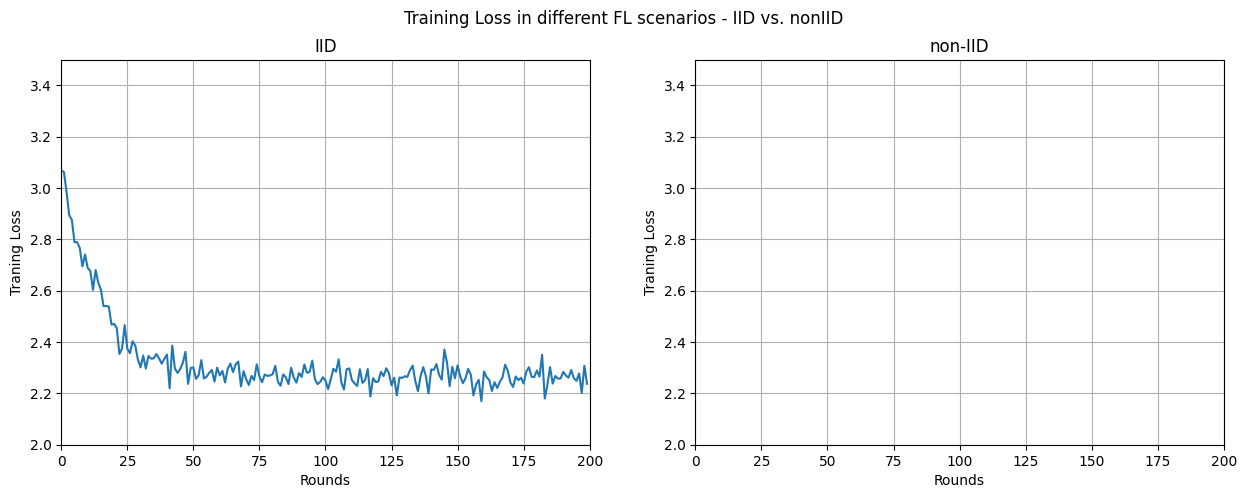

In [41]:
path = 'output_agnews/ag_news_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241118163901/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses.append(loss)

path = 'output_agnews/ag_news_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241119072504/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses2 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses2.append(loss)

#subplots 

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

sns.lineplot(x=range(len(losses)), y=losses, ax=ax[0])
sns.lineplot(x=range(len(losses2)), y=losses2, ax=ax[1])

#set overall title
fig.suptitle('Training Loss in different FL scenarios - IID vs. nonIID')

ax[0].set_title('IID')
ax[0].set_xlabel('Rounds')
ax[0].set_ylabel('Traning Loss')
ax[0].set_xlim(0, 200)
ax[0].set_ylim(2, 3.5)
ax[0].grid(True)

ax[1].set_title('non-IID')
ax[1].set_xlabel('Rounds')
ax[1].set_ylabel('Traning Loss')
ax[1].set_xlim(0, 200)
ax[1].set_ylim(2, 3.5)
ax[1].grid(True)



In [38]:
# Load the data
path = 'output_agnews/ag_news_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241119072504/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses.append(loss)


In [39]:
path = 'output_agnews/ag_news_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241118165343/training_loss.npy'

data = np.load(path, allow_pickle=True)

losses2 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses2.append(loss)


Text(0.5, 1.0, 'Loss of Federated Traning - Rolling Mean (10)')

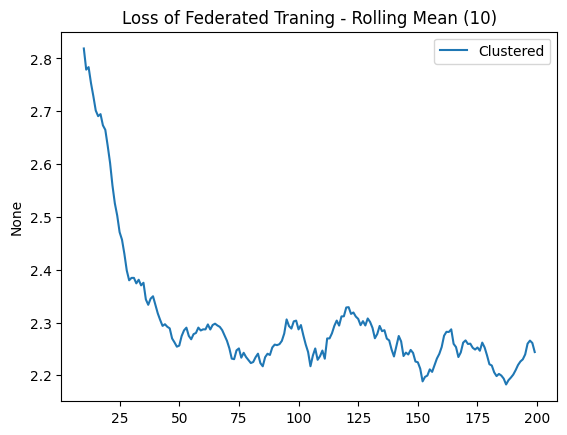

In [40]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#rolling mean
window = 10

losses = pd.Series(losses)
losses = losses.rolling(window).mean()
losses = losses[window:]
losses2 = pd.Series(losses2)
losses2 = losses2.rolling(window).mean()
losses2 = losses2[window:]


sns.lineplot(x=range(10, len(losses )+10), y=losses, label = 'FedAvg')
sns.lineplot(x=range(10, len(losses2)+10), y=losses2, label = 'Clustered')


plt.title('Loss of Federated Traning - Rolling Mean (10)')

In [29]:
from federated_learning.fed_global import calculate_similarity
import numpy as np
import seaborn as sns

path = 'output_agnews/ag_news_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241118165343'

sim = calculate_similarity(path = path,
                            n_clients = 20,
                            round = 50,
                            layer = 'all')

<Axes: >

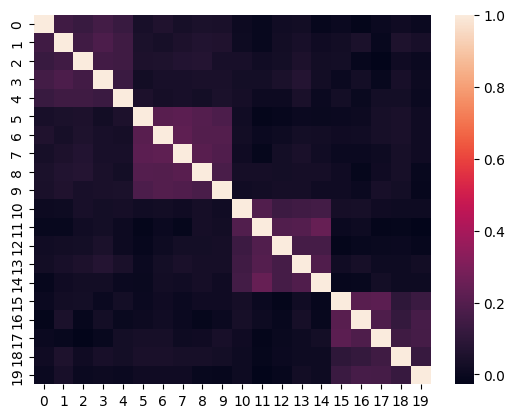

In [31]:
sim_matrix = np.load(path + '/similarity_B_round50.npy')
sns.heatmap(sim_matrix)

<Axes: >

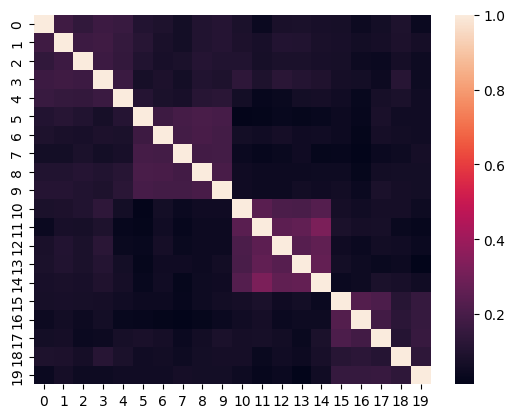

In [32]:
sim_matrix = np.load(path + '/similarity_A_round50.npy')
sns.heatmap(sim_matrix)